### Initialisation


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from datetime import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from dotenv import load_dotenv
import os
load_dotenv()


True

In [2]:
DATASET_URL = os.getenv("DATASET_URL")
scaler = MinMaxScaler()

features = ["MOIS_VENTE", "PRIX_NET", "FAMILLE","UNIVERS", "MAILLE", "LIBELLE", "CLI_ID"] 
cat_cols = ["FAMILLE", "UNIVERS", "MAILLE"]    

df = pd.read_csv(DATASET_URL)

### PreProcessing

#### Récupère des lignes selon une valeur d'une colonne

In [3]:
def linesByColumnValue(dataFrame, value, columnName = 'CLI_ID'):
    return dataFrame[dataFrame[columnName] == value]

#### Récupération & stat sur les prix d'une commande

In [4]:
def getClientExpense(dfClient, priceColumn = 'PRIX_NET'):
    prices = dfClient[priceColumn]
    return prices.sum(), prices.count(), prices.mean(), prices.min(), prices.max()

#### Formattage des données

In [5]:
def formatData(dfArray):
    # Création d'un encoder ordinal pour transformer les valeurs des features catégoriques     
    ordinal_encoder = OrdinalEncoder()      
    dfArray[cat_cols] = ordinal_encoder.fit_transform(dfArray[cat_cols]) 
    libelleColumn = dfArray['LIBELLE']
    array = dfArray.drop("LIBELLE",axis=1)
    return np.reshape(array, (len(array),len(array.columns))), libelleColumn

In [6]:
def getDistinctedColumn(dFrames, column):
    return dFrames.drop_duplicates(subset=[column], ignore_index=True)[column]

In [7]:
def pricesStats(cliDf, dfRow):
    psum, pcount, pmean, pmin, pmax = getClientExpense(cliDf)
    # "_P" for price
    dfRow["ART_PMAX"] = pmax
    dfRow["ART_PMIN"] = pmin
    dfRow["NB_ARTICLE"] = pcount
    dfRow["ART_PMOYEN"] = pmean
    return dfRow

#### Création dataset

In [8]:

# globalDf, clientIds, paramNames = df, clientsLines, familysLines (univers ou maille)
def createClientData(globalDf, clientIds, paramNames):
    column = np.array(paramNames)
    clientIds = np.array(clientIds)
    column = np.insert(column, 0,'CLI_ID')
    clientDf = pd.DataFrame(columns=column)
    
    #### DEBUG #####
    # clientIds = [clientIds[0]]
    # clientIds = clientIds[int(len(clientIds)*30/100)]
    # clientIds = clientIds[np.random.randint(len(clientIds), size=int(len(clientIds)*20/100))]
    clientIds = clientIds[np.random.randint(len(clientIds), size=int(8000))]
    # clientIds = clientIds[np.random.randint(13, size=int(13))]
    
    for idClient in clientIds:
        # Create and format new row
        newRow = pd.DataFrame({'CLI_ID': [idClient]}, columns=column)
        newRow.iloc[0, 1:len(paramNames)+1] = 0
        clientPurchase = linesByColumnValue(globalDf, idClient)

        # TEST TICKET STATS
        copy = clientPurchase.copy()
        dfprix = copy.groupby(["TICKET_ID", 'CLI_ID'], as_index = False)
        listDfPrix = dfprix['PRIX_NET'].sum()

        # Add ticket count
        newRow['NB_TICKET'] = len(listDfPrix)

        # Add mean of ticket price
        newRow['TICKET_PMOYEN'] = listDfPrix['PRIX_NET'].mean()

        # Add prices stats
        newRow = pricesStats(clientPurchase, newRow)

        grouped = clientPurchase.groupby('FAMILLE')
        for key in grouped.groups:
            count = len(np.array(grouped.groups[key]))
            newRow.loc[0, key] = count

        clientDf = pd.concat([clientDf, newRow], ignore_index=True)

    return clientDf
            


In [9]:
def applyPCAnScaler(data):
    # MinMax preprocessing in order to set de value between 0-1
    data_rescaled = scaler.fit_transform(data)

    pca = PCA(n_components = 0.95)
    pca.fit(data_rescaled)
    # Reduced datasaet
    return pca.transform(data_rescaled)

### Segmentation (Clustering)

#### Cherche le nombre de clusters le plus efficient

In [10]:
def elbowNSilhouette(array):
    x = array.drop('CLI_ID', axis=1)
    cluster_max = len(x) -1 if len(x) < 12 else 12
    wcss = []
    sil = []

    kRange = range(2, cluster_max)#np.delete(np.arange(12), 0)
    for i in kRange: 
        kmeans = KMeans(n_clusters = i, random_state=42)
        kmeans.fit(x) 
        wcss.append(kmeans.inertia_)
        labels = kmeans.labels_
        # sil.append(silhouette_score(x, labels, metric = 'euclidean'))
        sil.append(silhouette_score(x, labels))

    return wcss, sil, kRange, kRange[np.argmax(sil)]

#### Affichage graphique

In [11]:
def plotElbow(range, data) :
    plt.title('Elbow method')
    plt.plot(range, data, 'bx-') 
    plt.xlabel('Nombre de clusters')
    # wss =within-cluster sum of square
    plt.ylabel('Inertie (wss)')

In [12]:
def plotSilhouette(range, data) :
    plt.title('Silhouette method')
    plt.plot(range, data, 'bx-') 
    plt.xlabel('Nombre de clusters')

#### Recherche du nombre de clusters optimale

In [13]:
def cluster(array, acp=2, nbCluster=4):
    clientColumn = array['CLI_ID']
    array = array.drop('CLI_ID', axis=1)
    x = applyPCAnScaler(array)

    kmeans = KMeans(n_clusters=nbCluster, random_state=0)

    res = kmeans.fit_predict(x)
    kmeans.labels_
    kmeans.cluster_centers_

    #filter rows of original data
    #Getting unique labels
    u_labels = np.unique(res)
    # print(res)

    #plotting the results:
    for i in u_labels:
        plt.scatter(x[res == i , 0] , x[res == i , 1] , label = i)
    plt.legend()
    plt.show()
    df = pd.DataFrame(array)
    # df = df.assign(LIBELLE=libelleColumn)
    df = df.assign(CLUSTER = res)  
    df = df.assign(CLI_ID = clientColumn)
    return df

In [14]:
familysLines = getDistinctedColumn(df, 'FAMILLE')
clientsLines = getDistinctedColumn(df, 'CLI_ID')

In [15]:
clientDf = createClientData(df, clientsLines, familysLines)

In [16]:
wcss, sil, kRange, nClusters = elbowNSilhouette(clientDf)

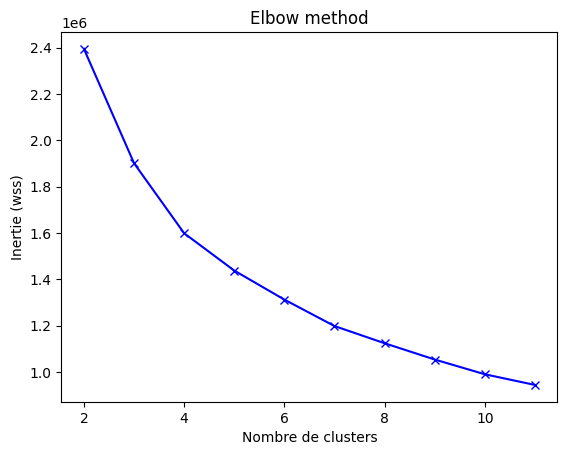

In [17]:
plotElbow(kRange, wcss)

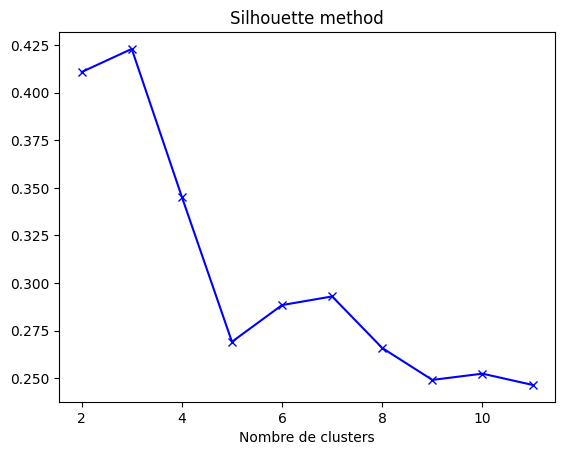

In [18]:
plotSilhouette(kRange, sil)

#### KMeans

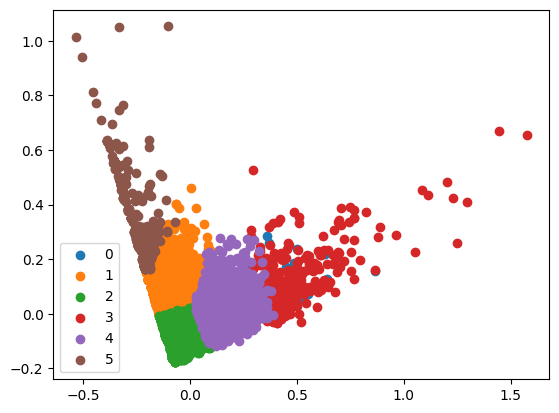

,HYGIENE,SOINS DU VISAGE,PARFUMAGE,SOINS DU CORPS,MAQUILLAGE,CAPILLAIRES,SOLAIRES,MULTI FAMILLES,SANTE NATURELLE,NB_TICKET,TICKET_PMOYEN,ART_PMAX,ART_PMIN,NB_ARTICLE,ART_PMOYEN,CLUSTER,CLI_ID
0,0,0,1,0,0,0,0,0,0,1.0,15.900000,15.90,15.90,1.0,15.900000,5,988779473
1,0,0,0,0,3,0,0,0,0,1.0,10.350000,4.45,1.95,3.0,3.450000,2,993099742
2,0,3,3,0,0,5,0,0,0,6.0,9.666667,15.90,2.95,11.0,5.272727,0,977717682
3,1,0,1,0,0,0,0,0,0,1.0,27.600000,19.60,8.00,2.0,13.800000,1,996656950
4,0,2,3,1,1,0,0,0,0,4.0,17.987500,17.95,2.95,7.0,10.278571,1,975337582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1,3,0,1,0,0,0,0,0,2.0,9.275000,6.70,1.95,5.0,3.710000,2,992546256
7996,3,1,0,2,0,1,0,0,0,2.0,9.775000,4.95,1.90,7.0,2.792857,2,985322829
7997,1,2,0,0,0,0,0,0,0,2.0,14.175000,19.90,1.50,3.0,9.450000,2,976503588
7998,9,5,0,6,1,6,0,0,0,17.0,6.411765,20.90,1.00,27.0,4.037037,0,994972195


In [19]:
# clusterised = cluster(clientDf, nbCluster=nClusters)
clusterised = cluster(clientDf, nbCluster=6)
clusterised

### Interpretation des clusters

In [20]:
def colors(array):
    return cm.rainbow(np.linspace(0, 1, len(array)))

In [52]:
def plot_bar(x, y, y_label='', x_label=''):
    plt.clf()
    plt.bar(x, y, color=colors(y))
    plt.xticks(x)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [58]:
def plot_bar_inverse(x, y, y_label='', x_label=''):
    fig, ax = plt.subplots()
    ax.cla()
    ax.barh(x, y, align='center', color=colors(y))
    ax.set_yticks(x)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [22]:
def plot_pie(array, labels, autopct=lambda x: '{:.0f}'.format(x*nb_vente_famille.sum()/100)):
    fig1, ax1 = plt.subplots()
    ax1.pie(array, 
                labels=labels,
                # explode=[0,0,0.2,0,0,0,0,0,0],
                autopct=autopct, 
                # labeldistance = 1.4,
                shadow=True,
                radius=1.5)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [60]:
def exploit_cluster(nb_clusters, df_clusterised, dataframes):
    for n in nb_clusters:
        print('\033[1m'+'Cluster N°',n)
        cluster_clients = df_clusterised[df_clusterised['CLUSTER'].isin([int(n)])]
        clients_purchase = dataframes[dataframes['CLI_ID'].isin(np.array(cluster_clients['CLI_ID']))]
        month_sales = clients_purchase.groupby("MOIS_VENTE")['MOIS_VENTE'].count()

        months = range(1,13)
        plot_bar_inverse(months,month_sales, y_label='Ventes', x_label='Mois')

        clients_purchase['PRIX_NET'].std()
        clients_purchase['PRIX_NET'].max()
        clients_purchase['PRIX_NET'].mean()
        clients_purchase['PRIX_NET'].min()

        plot_bar_inverse(['Min', 'Moy', 'Max', 'ET'], [clients_purchase['PRIX_NET'].min(),clients_purchase['PRIX_NET'].mean(),clients_purchase['PRIX_NET'].max(),clients_purchase['PRIX_NET'].std()], y_label='Ventes')
        
        nb_vente_famille = cluster_clients[['HYGIENE', 'SOINS DU VISAGE', 'PARFUMAGE', 'SOINS DU CORPS', 'MAQUILLAGE', 'CAPILLAIRES', 'SOLAIRES', 'MULTI FAMILLES', 'SANTE NATURELLE']].sum()
        plot_pie(nb_vente_famille, nb_vente_famille.index, autopct=lambda x: '{:.0f}'.format(x*(nb_vente_famille.sum()/100)*100/nb_vente_famille.sum()))

Cluster N° 5


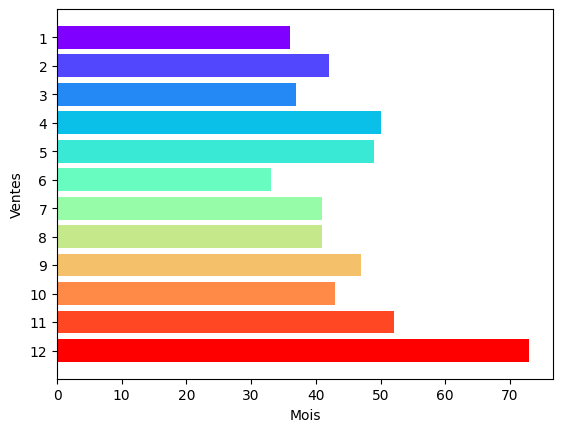

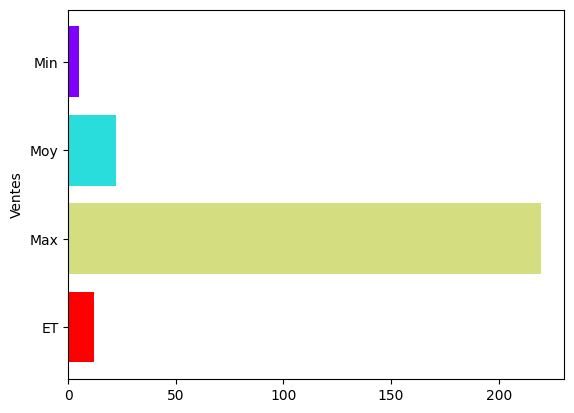

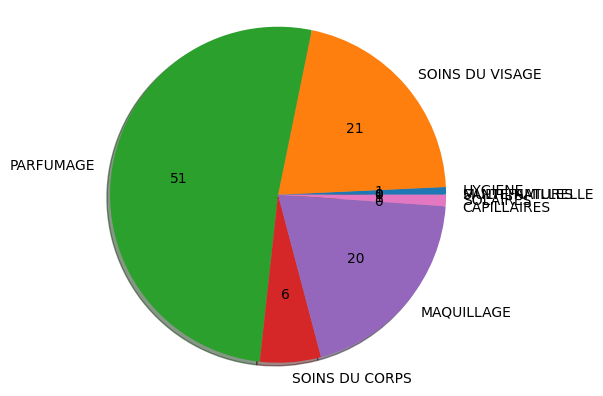

Cluster N° 2


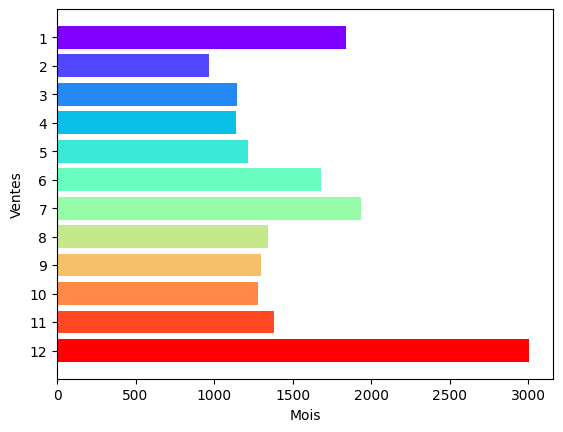

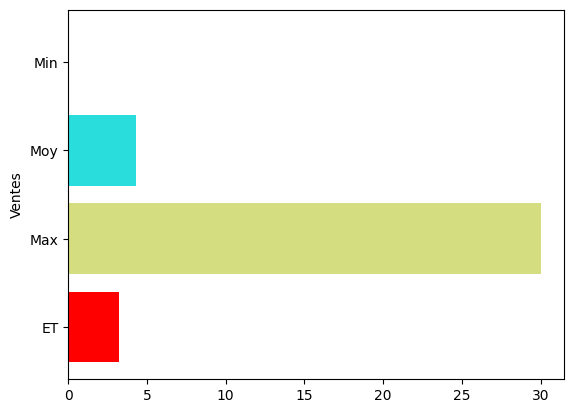

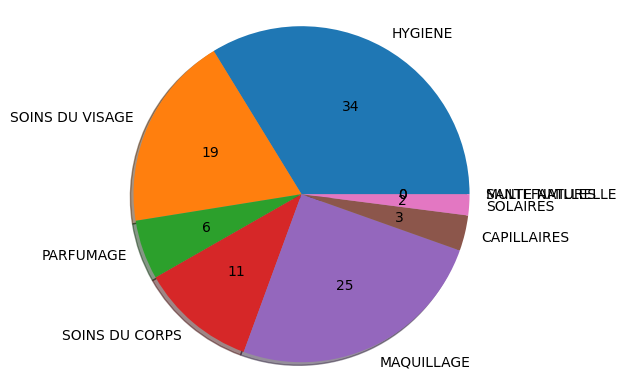

Cluster N° 0


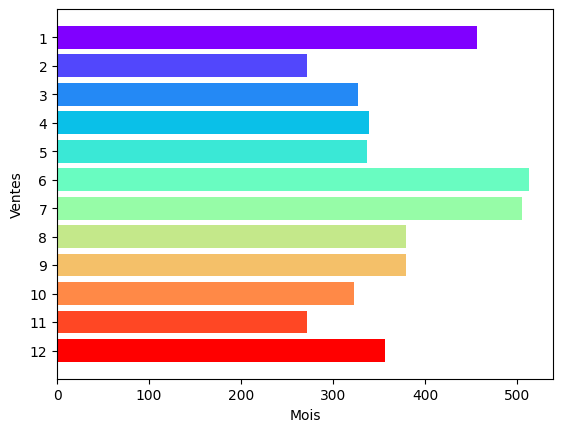

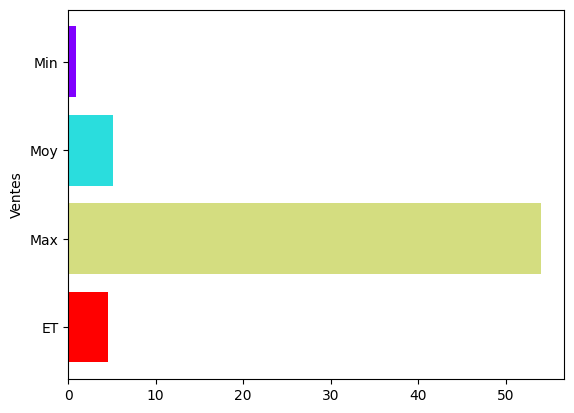

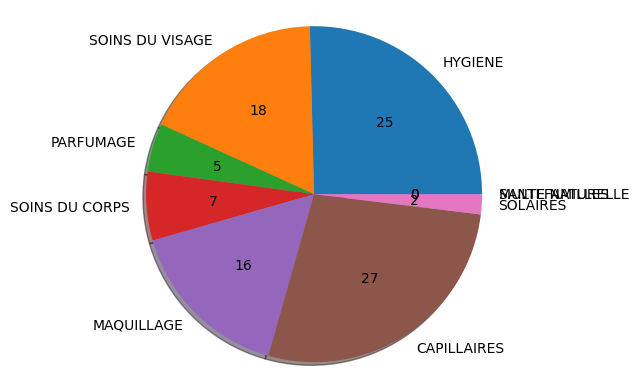

Cluster N° 1


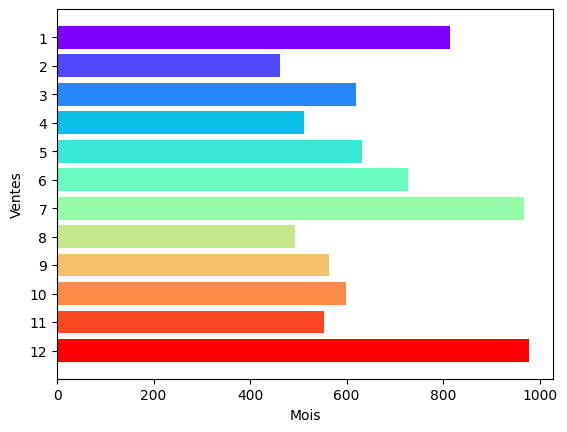

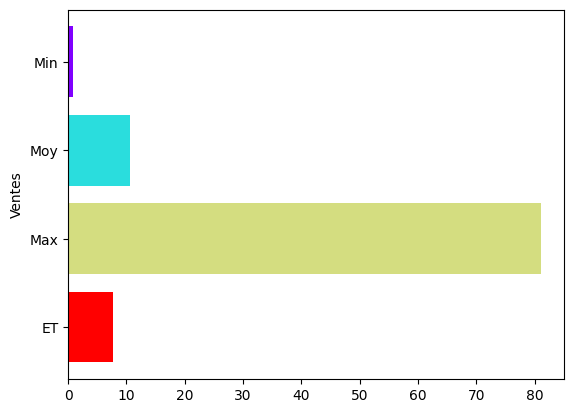

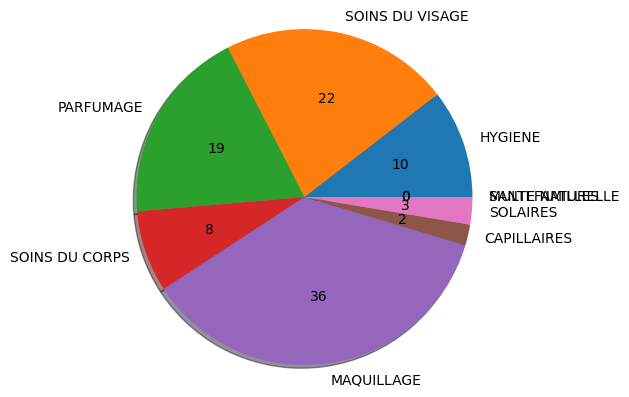

Cluster N° 4


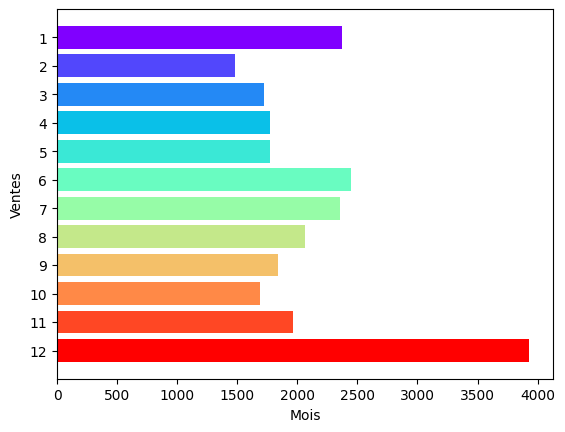

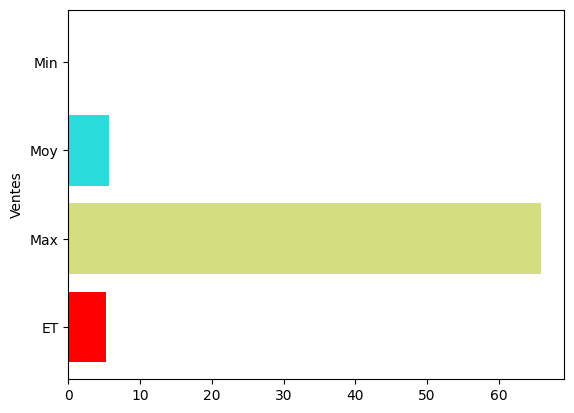

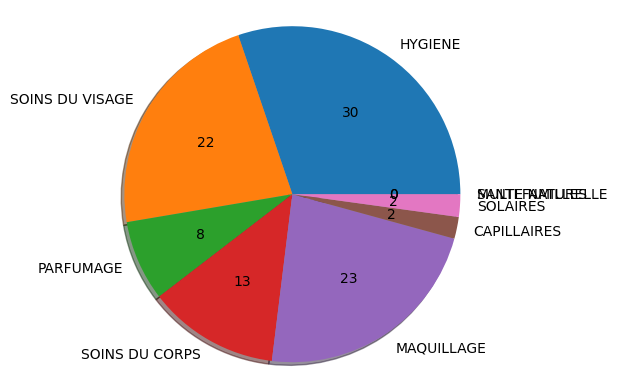

Cluster N° 3


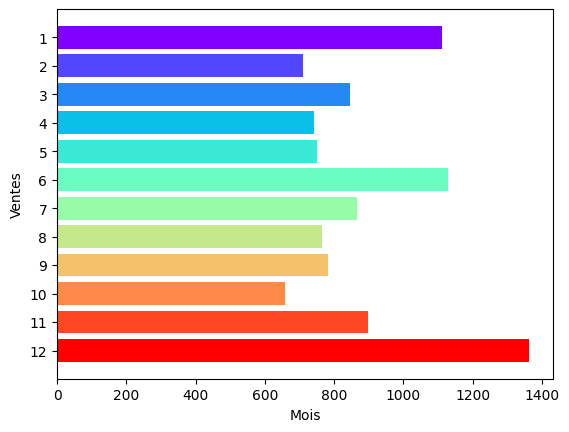

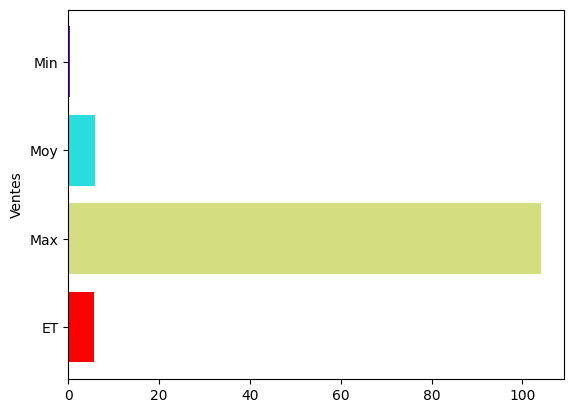

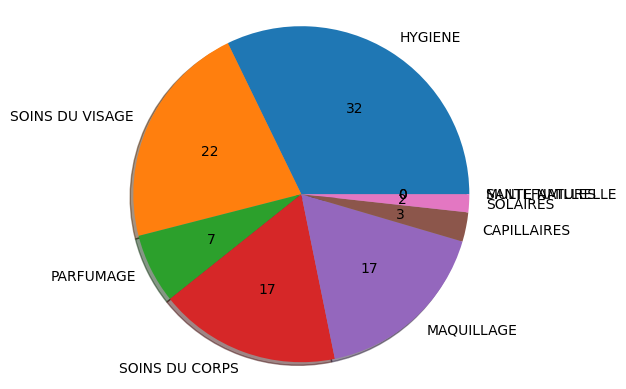

In [61]:

exploit_cluster(getDistinctedColumn(clusterised, 'CLUSTER'), clusterised, df)

### Validation

In [ ]:
def prepare_dataset(dataset):
    X_ = list() 
    y_ = list()
    # for column, row in dataset:
    y_.append(dataset['CLUSTER'])
    dataset = dataset.drop('CLUSTER', axis=1)
    
    X_.append(dataset.values)
    X_ = np.array(X_)
    X_ = X_.reshape(len(dataset), len(dataset.columns))

    y_ = np.array(y_)
    y_ = y_.reshape(len(dataset))
    return X_, y_ 

In [ ]:
x_train, label_train = prepare_dataset(clusterised)

In [ ]:
# test_size: what proportion of original data is used for test set
x_train, x_test, label_train, label_test = train_test_split( x_train, label_train, test_size=0.30)

In [ ]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_train)
# Apply transform to both the training set and the test set.
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#### Trouve la meilleure valeur de K (voisins)

Text(0, 0.5, 'Testing Accuracy')

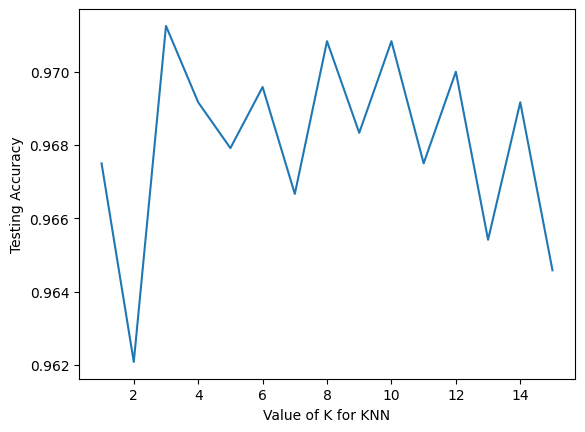

In [ ]:
scores = []
k_range = range(1, 16)
# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, label_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.accuracy_score(label_test, y_pred))
max = np.amax(scores) 
itemindex = np.where(scores==max)
neighbors_max = itemindex[0]+1

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

#### KNN

In [ ]:
KNN = KNeighborsClassifier(int(neighbors_max[0]))
KNN.fit(x_train, label_train)


KNeighborsClassifier(n_neighbors=3)

In [ ]:
pred = KNN.predict(x_test)
# predicted_classes = np.argmax(pred, axis=0)
print(metrics.accuracy_score(pred, label_test))
report = classification_report(pred, label_test)
print(report)   

0.97125
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       232
           1       0.99      0.98      0.99      2080
           2       0.89      0.97      0.92        88

    accuracy                           0.97      2400
   macro avg       0.90      0.95      0.93      2400
weighted avg       0.97      0.97      0.97      2400



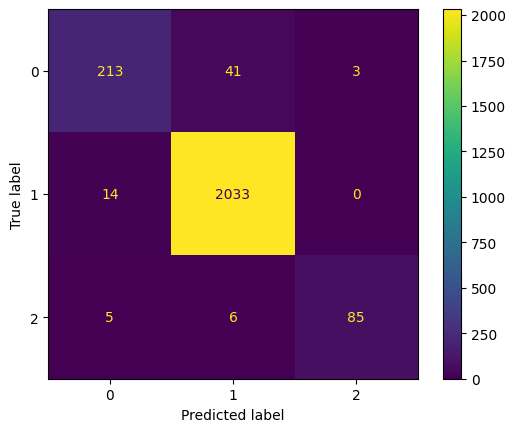

In [ ]:
cm = confusion_matrix(label_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Cross validation

In [ ]:
# Use the cross_val_score function to perform 10-fold cross-validation
scores = cross_val_score(KNN, x_test, label_test, cv=10)

# Print the mean and standard deviation of the scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.02)


In [ ]:
def recommandation(cliId, dataset, dataframes):
    today = datetime.now()
    # Récupère les données du client dont le cluster
    client = dataset[dataset['CLI_ID'].isin([cliId])]
    # Récupère les produits déjà commandé par le client
    bought_products = dataframes[dataframes['CLI_ID'].isin([cliId])]
    bought_products = getDistinctedColumn(bought_products, 'LIBELLE')

    # Récupère tout les id clients qui sont dans le même cluster
    cluster_clients = dataset[dataset['CLUSTER'].isin([int(client['CLUSTER'])])]['CLI_ID']

    # Recupère les produits distint que tout ces client ont commandés
    potentional_products = dataframes[dataframes['CLI_ID'].isin(np.array(cluster_clients))]
    potentional_products = getDistinctedColumn(potentional_products, 'LIBELLE')
    potentional_products = potentional_products[~potentional_products.isin(bought_products)]

    product = potentional_products[random.randint(0, len(potentional_products)-1)]
    products_libelle = dataframes.loc[dataframes['LIBELLE'].isin([product])]
    # Filtre par mois car le prix peux varier
    products = products_libelle.loc[products_libelle['MOIS_VENTE'].isin([today.month])]

    # Si l'article n'est pas  trouvé dans le mois courant alors on prend la première valeur
    if products.empty:
        product = products_libelle
    else: 
        product = products

    product = product.drop(['TICKET_ID', 'MOIS_VENTE', 'CLI_ID'], axis=1).head(1).reset_index(drop='true')

    return product


In [ ]:
cli = input('Entrez un ID client: ')
recommanded_product = recommandation(int(cli), clusterised, df)
recommanded_product

,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE
0,2.94,SOINS DU VISAGE,VIS_DEMAQ PUR,VIS_PUR,LAIT DE TOILETTE PC 200ML
